In [1]:
# The script and ipython notebooks were originally saved in the G drive folder, together with the data. 
# On 10/1/2024 I have placed the script and ipython notebooks on the Github folder.

In [2]:
%matplotlib notebook
from beam_tomo import *
plt.rcParams['figure.max_open_warning'] = 50
from scipy.optimize import curve_fit

The linear function is: y = 1.0 * x + 1.0


# Previous work on beam tomography 

Link for report with previous beam tomography:(link)[https://docs.google.com/document/d/1uOGDw6qHZKiGV28OnOs043JRSdri8LaaIsc8oYo4Qxg/edit#bookmark=id.4wuwfttv8kr]


# Description of measurements 

1. Acquisition #1 - 17.29.50 tomography.pkl (z from 14.6 to 16.6, PWM = 7%, exp = 1/40 000, 25us)
2. Acquisition #2 - 17.44.35 tomography.pkl (z from 14.6 to 17.6, PWM = 7%, exp = 1/40 000, 25us)

3. Acquisition #3 - 17.50.51 tomography.pkl (z from 14.6 to 18.6, PWM = 8%, exp = 1/40 000, 25us) - seems decoupled

4. Acquisition #4 - (re-coupled) - 17.56.48 tomography.pkl (z from 14.7 to 18.7)
5. Acquisition #5 - 18.02.48 tomography.pkl -same as acquisition 4, after rechecking coupling;


# List and load measurements 

In [3]:
# Access folder with data in G drive
folder_path = "G:\Shared drives\VitreaLab Share\Lab Data\Light Engine Team\X-Reality Projects (XR)\Augmented Reality (AR)\Lab Data\AR\2023-12-05\beam_tomography\\"
folder_path = r"G:\Shared drives\VitreaLab Share\Lab Data\Light Engine Team\X-Reality Projects (XR)\Augmented Reality (AR)\Lab Data\AR\2023-12-05\beam_tomography\\"
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
filenames = [item for item in files if ".pkl" in item]

# Parameters
filename = filenames[4]
file_path = os.path.join(folder_path, filename)
shape = (3, 10)
roi_width = 100

# Load data
tomo = Tomography(file_path, (3,10), roi_width)
tomo.load_data()

Loaded
Tomography measurement:

        - Filename = G:\Shared drives\VitreaLab Share\Lab Data\Light Engine Team\X-Reality Projects (XR)\Augmented Reality (AR)\Lab Data\AR\2023-12-05\beam_tomography\\18.02.48 tomography.pkl

        - Number of beam rows = 3

        - Number of beam cols = 10

        - Z-spacing: 0.100mm

        - Number of cross sections: 40
        


# Find rotation angle and spacing

In [4]:
tomo.find_rot_spacing(angle_min = 45, angle_max = 47, angle_step = 0.25)

Extracting rotation angle for the lowest z cross section.


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:07<00:00,  1.07it/s]


Optimal rotation angle = 46.75deg
Extracting the grid spacing
Average spacing [px] between beams = 145.95
Updating the rotation angle and rotated image for each cross section.


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.31it/s]


# Extract beam coord of first layer --> tomo.coord_init()

In [5]:
tomo.init_coords()

Coordinates of beam in first layer were determined.


# Extract single beam positions and width across cross-sections

In [ ]:
#Single beam
id_x, id_y = 0, 0
tomo.complete_beam_coords(id_x, id_y, debug = False)

In [ ]:
#Iterative - just for monitoring processes
#for id_x in tqdm(range(tomo.shape[0])):
#    for id_y in range(tomo.shape[1]):
#        print(f"id_x = {id_x}, id_y = {id_y}")
#        tomo.complete_beam_coords(id_x, id_y, debug = False)

In [6]:
#All beams
tomo.complete_all_beams_coords(debug = False)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.57it/s]


# Plot single beam

## plot beam trajectory and width

In [ ]:
id_x = 0
id_y = 7
beam_i = tomo.beam_l[id_x][id_y]
beam_i.plot_trajectory()


## Plot single beam width evolution

In [ ]:
id_x = 1
id_y = 2
beam_i = tomo.beam_l[id_x][id_y]
beam_i.plot_width(limit_z_fit=False)


## Plot ROIs

In [ ]:
id_x = 0
id_y = 1
beam_i =tomo.beam_l[id_x][id_y]
beam_i.plot_rois()
    

## Plot gaussian fits

In [ ]:
plt.figure()
plt.plot(roi_sum_row_arr)

In [32]:
#correct background

def find_backg_function(arr, debug = True):
    """
    Finds linear function mx+b that represents background.
    
    return: m, b
    """
    
    min_val_m, min_idx_m =  find_min_and_argmin(arr[:int(len(roi_sum_row_arr)/2)])
    min_val_p, min_idx_p =  find_min_and_argmin(arr[int(len(roi_sum_row_arr)/2):])

    p1 = (min_idx_m, min_val_m)
    p2 = (min_idx_p + int(len(arr)/2), min_val_p)
    if debug:
        print("p1: ", p1)
        print("p2: ", p2)

    m, b = find_linear_function(p1, p2)
    return m,b


def subtract_linear_background(arr, debug = False):
    """
    1. Extract background, represented by linear function
    2. Subtract linear background from arr
    
    """
    
    m, b = find_backg_function(arr, debug = debug)
    idx_arr = range(len(arr))
    backg_arr = m*idx_arr + b
    
    return arr - backg_arr
    

In [27]:
find_background(roi_sum_row_arr)

(0.007945078389257431, 0.0)

p1:  (0, 0.0)
p2:  (99, 0.06140513771427541)
p1:  (0, 0.0)
p2:  (99, 0.06140513771427541)


<IPython.core.display.Javascript object>


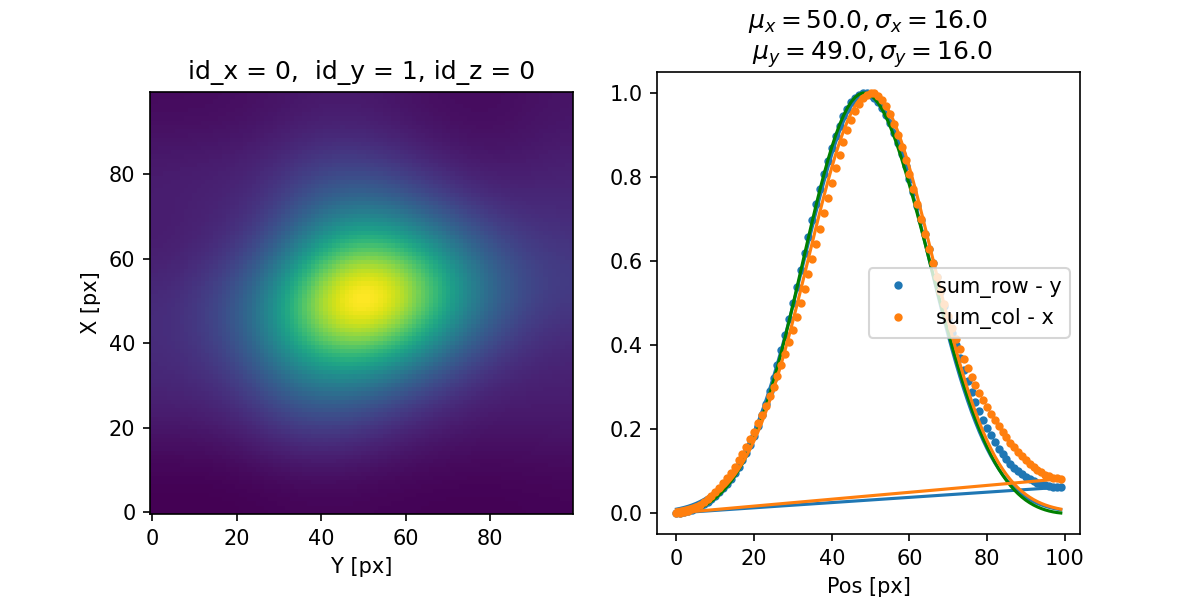

In [36]:
#beam_i.plot_gauss_fit()
id_x = 0
id_y = 1
beam_i =tomo.beam_l[id_x][id_y]

for id_z in range(len(beam_i.roi_l)):
    #extract parameters and roi from beam_i
    col_mu, row_mu, col_sigma, row_sigma = beam_i.roi_fit_params_l[id_z] #[col_mu, row_mu, col_sigma, row_sigma]
    roi_i = beam_i.roi_l[id_z]

    #Project intensity map of ROI into x and y --> I(x) = roi_sum_col, I(y) = roi_sum_row
    roi_sum_row_arr = np.sum(roi_i, axis=0)
    roi_sum_col_arr = np.sum(roi_i, axis=1)

    #Normalise I(x) and I(y)
    roi_sum_row_arr = normalise(roi_sum_row_arr)
    roi_sum_col_arr = normalise(roi_sum_col_arr)
    row_idx_arr = np.arange(len(roi_sum_row_arr))
    col_idx_arr = np.arange(len(roi_sum_col_arr))
    
    #Correct background - background has a slope --> mx+b --> subtract background(x) from I(x)
    m_row, b_row = find_backg_function(roi_sum_row_arr, debug = True)
    row_backg_fit = m_row * row_idx_arr + b_row
    
    roi_sum_row_arr_ = subtract_linear_background(roi_sum_row_arr, debug = True)
    roi_sum_row_arr_ = normalise(roi_sum_row_arr_)
    
    m_col, b_col = find_backg_function(roi_sum_col_arr, debug = False)
    col_backg_fit = m_col * col_idx_arr + b_col
    
    
    #Plots
    f, ax = plt.subplots(ncols=2, nrows = 1, figsize = (8,4))
    ax[0].imshow(roi_i, origin = "lower")
    ax[0].set_xlabel("Y [px]")
    ax[0].set_ylabel("X [px]")
    ax[0].set_title(f"id_x = {id_x},  id_y = {id_y}, id_z = {id_z}")


    #plot sum_row - y
    ax[1].plot(row_idx_arr, roi_sum_row_arr, ".",label = "sum_row - y", color = "tab:blue")
    row_fit = gaussian(row_idx_arr, row_mu, row_sigma)
    ax[1].plot(row_idx_arr, row_fit, color = "tab:blue")
    ax[1].plot(row_idx_arr, row_backg_fit)
    ax[1].plot(row_idx_arr, roi_sum_row_arr_, color = "green")

    #plot sum_col - x
    ax[1].plot(col_idx_arr, roi_sum_col_arr, ".",label = "sum_col - x", color = "tab:orange")
    col_fit = gaussian(col_idx_arr, col_mu, row_sigma)
    ax[1].plot(col_idx_arr, col_fit, color = "tab:orange")
    ax[1].plot(col_idx_arr, col_backg_fit)

    ax[1].set_title(f"$\mu_x = {{{col_mu:.1f}}},  \sigma_x = {{{col_sigma:.1f}}}$ \n $\mu_y = {{{row_mu:.1f}}},  \sigma_y = {{{row_sigma:.1f}}}$")
    ax[1].set_xlabel("Pos [px]")
    ax[1].legend()

    break

# Plot cross sections

In [ ]:
#for i in range(tomo.n_sections):
for i in range(10):
    tomo.plot_cross_section(i)

In [ ]:
tomo.plot_cross_section(35)
tomo.plot_cross_section(0)


# Extract beam parameters (tilt_x, tilt_y, div_x, div_y) 

## Find direction cosines

In [ ]:
tomo.set_max_z(15.5)
tomo.find_dir_cos(debug = True) #loops over beam method beam_i.find_dir_cos()

In [ ]:
tomo.find_div(debug = True) #loops over beam method beam_i.find_div

## Find divergence angle

In [ ]:
#for id_x in range(tomo.shape[0]):
#    for id_y in range(tomo.shape[1]):

id_x = 0
id_y = 0
beam_i = tomo.beam_l[id_x][id_y]

#set max_z_id
max_z_idx = 8

#extract beam_width arrays and z_arr
beam_width = np.array(beam_i.beam_width_l)
beam_width_x = beam_width[:max_z_idx, 0]
beam_width_y = beam_width[:max_z_idx, 1]
z_arr = np.array(beam_i.beam_coord_l)[:max_z_idx, 2]
z_px_arr = (z_arr*10**-3)/(tomo.pixel_size)

#plot beam_width_x vs z_arr and beam_width_y vs z_arr
f, ax = plt.subplots(figsize = (4, 4))
ax.plot(z_px_arr, beam_width_x , ".", label = "x sigma")
ax.plot(z_px_arr, beam_width_y, ".",label = "y sigma")
ax.set_ylabel("Width [px]")
ax.set_xlabel("Z pos [px]")
ax.legend()


#fit linear curve to width vs z to extract div_angle
#z_arr = beam_i.beam_coord_l[]



In [ ]:
print(e_x, e_y, e_z)

In [ ]:
np.linalg.norm([e_x, e_y, e_z])

In [ ]:
pos(0, 12, 1)

In [ ]:
id_x = 0
id_y = 0
for id_x in range(tomo.shape[0]):
    for id_y in range(tomo.shape[1]):
        beam_i =tomo.beam_l[id_x][id_y]
        beam_i.plot_trajectory(limit_z_fit = True)

# 8. Visualise cross sections with location of beams and ROIs

# 9. Visualise single beam (3D)

## Visualise first layer with ROI

In [ ]:
time_start = time.time()

#call tomo.coord_init()
exp_num_peaks = tomo.shape[0]*tomo.shape[1]
cross_i = tomo.cross_sect_l[0]
spacing = int(cross_i.spacing_px)
image_i = tomo.cross_sect_l[0].image_rot

peak_arr = feature.peak_local_max(image_i, num_peaks = exp_num_peaks, min_distance = int(spacing*0.9))

#pass info to cross section
#tomo.cross_sect_l[0].beam_coord_l = peak_arr

#pass info to each beam in tomo.beam_l
#for beam_i in tomo.beam_l:
#    beam_i.beam_coord_l = peak_arr

#time_stop = time.time()
#print("The task took", time_stop-time_start, "s to complete.")

## Beam and cross section classes

## Collect cross sections of the same beam for different z